In [1]:
from flu_matrix_completion import *
print('The scikit-learn version is {}.'.format(sklearn.__version__))
print('scikit-learn version >=1.3.1 is needed as it contains a version of sklearn.tree.DecisionTreeRegressor which is needed for this matrix completion model (this version can handle NAN values in training data).')

The scikit-learn version is 1.3.1.
scikit-learn version >=1.3.1 is needed as it contains a version of sklearn.tree.DecisionTreeRegressor which is needed for this matrix completion model (this version can handle NAN values in training data).


<Axes: ylabel='sampleID'>

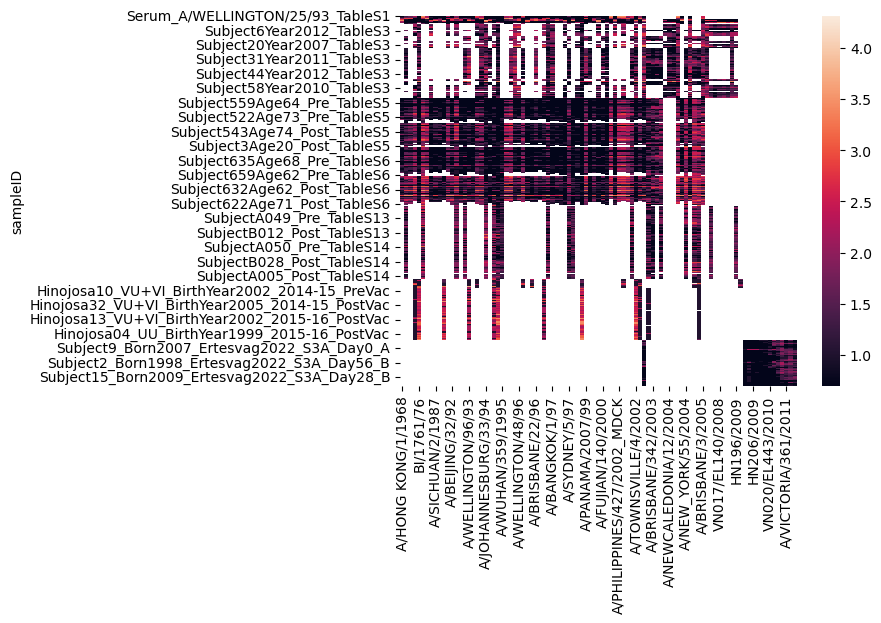

In [2]:
# Load in antisera-virus data as pd.DataFrames
all_HI_df = pd.read_csv("data/all_data.csv", index_col='sampleID')
all_antisera_df = pd.read_csv("data/all_data_antisera_table.csv", index_col='sampleID')
all_HI_data_tables  = HI_data_tables() # Create HI_data_tables object
all_HI_data_tables.add_HI_data(HI_df=all_HI_df,
                               antisera_df=all_antisera_df) # Add data from Tal's ad Rong's original paper
all_HI_data_tables.compute_virus_dates()
sns.heatmap(all_HI_data_tables.HI_data)

# Grid Search Analysis on Matrix Completion Model
Find which hypereparameters can be tuned to improve the performance of matrix completion between two datasets with low transferability

## General Schema of Grid Search


In [4]:
np.random.seed(10) # Set random seed

sourceIDs = ['TableS3.2', 'TableS3.1'] # Names of tables to train ensemble on
groupIDs = ['TableS1', 'TableS5', 'TableS6', 'TableS13', 'TableS14', 'fon_children', 'fon_ferrets', 'hin_vu14vi15', 'hin_vu15vi16', 'hin_u15u16',  ] # Names of tables to make predictions on
f_sample = 0.5 # Stick with training on 50% of sera data, it has been shown not to significantly affect performance
n_features_options = [5, 10, 15, 20, 25] # Number of overlapping viruses to train on 
train_trees_options = [10, 50, 100, 500, 1000] # Number of total trees to grow in ensemble
best_trees_options = [1, 3, 5, 8, 10, 20, 50, 100, 200, 300, 500, 750] # Number of best trees to use in each ensemble
    
ensemble_count=0 # Counts number of ensemble models trained
n_features_info = [] # Information on each comparison of a source and target table

results = []
for sourceID in sourceIDs:
    source_table = all_HI_data_tables.select_HI_data_by_group(group=[sourceID]).dropna(axis=1, how='all').dropna(axis=0, how='any')
    for groupID in groupIDs:
        target_table = all_HI_data_tables.select_HI_data_by_group(group=[groupID]).dropna(axis=1, how='all').dropna(axis=0, how='any')
        n_features_info.append(f"sourceID: {sourceID}, groupID: {groupID}, number of intersecting viruses: {len(set(source_table.columns).intersection(set(target_table.columns)))}")
        comparison_name = f"{sourceID}_to_{groupID}"
        for n_features in n_features_options:
            for train_trees in train_trees_options:
                # Train ensemble and keep all trees in list. When analyzing affect of the number of best trees to use, take it from this list to avoid retraining the model as it is redundant
                m_best_trees_trainer_lists_full, intersection = train_cross_dataset_model(source_table,
                                                                                          target_table,
                                                                                          n_feature=n_features,
                                                                                          f_sample=f_sample,
                                                                                          train_trees=train_trees,
                                                                                          best_trees=train_trees)
                intersection = [i for i in target_table.columns if i in intersection] # Contains viruses ordered by date
                ensemble_count += 1 # Counts number of times an ensemble model needs to be trained
                best_trees_options_adjusted = [i for i in best_trees_options if i <= train_trees]
                for best_trees in best_trees_options_adjusted:
                    full_comparison_name = f"{comparison_name}_n_features_{n_features}_train_trees_{train_trees}_best_trees_{best_trees}"
                    m_best_trees_trainer_lists_subset = {key:val[:best_trees] for key, val in m_best_trees_trainer_lists_full.items()} # 
                    target_table_predictions = compute_predicted_df(m_best_trees_trainer_lists_subset, intersection, target_table) # Perform predictions
                    RMSE = np.sqrt(np.mean((target_table_predictions - target_table)**2)) # Compute RMSE between actual and predicted HAI values (log10 scaled)
                    print(f"ensemble no. {ensemble_count}, full_comparison_name: {full_comparison_name}, RMSE: {RMSE}")
                    results.append([full_comparison_name, RMSE])
                print()

# Write grid search results to the following 2 .csv files

n_features_info_df = pd.DataFrame(n_features_info)
n_features_info_df.columns = ['n_features_info']
n_features_info_df.to_csv('n_features_info.csv')
                
results_df = pd.DataFrame(results)
results_df.columns = ['full_comparison_name', 'RMSE']
results_df.to_csv("grid_search_results.csv")

ensemble no. 1, full_comparison_name: TableS3.2_to_TableS1_n_features_5_train_trees_10_best_trees_1, RMSE: 0.8521655217106443

ensemble no. 2, full_comparison_name: TableS3.2_to_TableS5_n_features_5_train_trees_10_best_trees_1, RMSE: 0.39540571788674245

ensemble no. 3, full_comparison_name: TableS3.2_to_TableS6_n_features_5_train_trees_10_best_trees_1, RMSE: 0.4148988311102784

ensemble no. 4, full_comparison_name: TableS3.2_to_TableS13_n_features_5_train_trees_10_best_trees_1, RMSE: 0.2434165378718968

ensemble no. 5, full_comparison_name: TableS3.2_to_TableS14_n_features_5_train_trees_10_best_trees_1, RMSE: 0.361245178689545

ensemble no. 6, full_comparison_name: TableS3.2_to_fon_children_n_features_5_train_trees_10_best_trees_1, RMSE: 0.43074430450227535

ensemble no. 7, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_5_train_trees_10_best_trees_1, RMSE: 0.7235855842764702

ensemble no. 8, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_5_train_trees_10_best_tr

In [ ]:
'''
Must only train trees on viruses in intersection
'''

In [ ]:
'''
Last full comparison:
ensemble no. 25, full_comparison_name: TableS3.2_to_TableS1_n_features_25_train_trees_1000_best_trees_750, RMSE: 0.6318337575791984
One with Trouble:
'TableS3.2_to_TableS5_n_features_5_train_trees_10_best_trees_1'

File /mnt/d/School_Wasteland/einav_lab_work/Nicks_stuff/flu_matrix_completion.py:874, in compute_predicted_df(m_best_trees_trainer_lists_per_target_virus, intersection, target_dataset)
    870     for key in m_best_trees_trainer_lists_per_target_virus:
    871 #         for sera in target_dataset.index:
    872 #             print()
    873         m_best_trees_trainer_lists = m_best_trees_trainer_lists_per_target_virus[key]
--> 874         df.loc[:, key] = predict_target(m_best_trees_trainer_lists, target_dataset)
    876     return df.dropna(axis=0, how='all')

File /mnt/d/School_Wasteland/einav_lab_work/Nicks_stuff/flu_matrix_completion.py:835, in predict_target(m_best_trees_trainer_lists, target_dataset)
    833 for l in m_best_trees_trainer_lists:
    834     dtr, _, _, virus_col_sel, feature_t, _, _ = l
--> 835     X = target_dataset[virus_col_sel]
    836     col_mean = (X).apply(lambda x: x.mean(), axis=1)
    837     centering_matrix =  np.outer(np.ones(X.shape[1]), col_mean).T

KeyError: "['VN016/EL135/2008'] not in index"


'''


compute_predicted_df(m_best_trees_trainer_lists, intersection, target_table)